# 03 Likelihood modeling with PyTorch 
## Introduction
In this exercise, we use machine learning to model a 2-parameter, 1D likelihood $p(x|\theta)$ from training data. We shall take advantage of the following result: for a balanced training set comprising data from two classes with targets $t = 1$ and $t = 0$ a model trained using either the quadratic loss or the cross-entropy loss approximates the (discriminant) function

\begin{align}
    D(\mathbf{x}) & = \frac{p(\mathbf{x}|1)}{p(\mathbf{x}|1) + p(\mathbf{x}|0)}.
\end{align}

Write $\mathbf{x} = x, \theta$. From the above, it follows that

\begin{align}
    \frac{D(x, \theta)}{1 - D(x, \theta)} & = \frac{p(x, \theta|1)}{p(x, \theta|0)}, \\
                    & = \frac{p(x, \theta|1)}{f(x) \, p(\theta|1)},
\end{align}

where we have chosen $p(x, \theta | 0)$ to be 
$f(x) \, p(\theta|1)$ with $f(x)$ a *known* probability density and  $p(\theta | 1) = \int p(x, \theta| 1) \, dx$ is a *marginal* density of the joint density $p(x, \theta | 1)$. Then, we can write

\begin{align}
    p(x | \theta, 1) & = \frac{p(x, \theta|1)}{p(\theta|1)} = f(x) \left[ \frac{D(x, \theta)}{1 - D(x, \theta)} \right] .
\end{align}

## Exercise

The goal is to model likelihoods clustered around a given parameter point $\theta_0$. For simplicity, we use a generalized gamma density throughout and use one with fixed parameters as the known density $f(x)$. In many applications, the training data $\{ (x_m, \theta_m) \}$ are given and the marginal density $p(\theta |  1)$ is typically unknown. 

However, in this exercise the training data are generated by first sampling $\theta$ from a *known* density $p(\theta | 1)$ about the point $\theta_0$ and for every point $\theta_m$ sampling from the likelihood $p(x | \theta, 1)$. In a real application the functional form of the likelihood is either unknown or intractable, hence the attempt to model it using machine learning techniques. 

But in this exercise, we'll be able to check how well the algorithm has worked because we know the exact form of $p(x | \theta, 1)$. The detailed algorithm for generating the data is given below. 

### Generation of data

The algorithm below is implemented in 00_generate.ipynb.

  1. $t = 1$
     1. Generate $N$ sets of parameters $\theta = a, c$ from the generalized gamma density with $\theta_0 = A, C$, where $A = C = 1.5$, 
\begin{align}
    p(a | A, C) & = |C| \frac{a^{CA - 1} \exp(-a^C)}{\Gamma(A)} ,
\end{align}
and similarly for $c$.
     1. For each parameter point $\theta_m = a_m, c_m$ generate a single datum $x_m$ using 
    \begin{align}
    p(x | a_m, c_m) & = |c_m| \frac{x^{c_m a_m - 1} \exp(-x^{c_m})}{\Gamma(a_m)} .
    \end{align}
     1. Assign $t = 1$ to these data: $\{ \color{blue}{(1, x_m, a_m, c_m)}, m = 1,\cdots,N \}$. <p>
  1. $t = 0$
     1. Generate $N$ sets of parameters as for $t = 1$.
     1. Generate $N$ values $\{ x_m, m = 1,\cdots,N \}$ from the fixed density
     \begin{align}
        f(x) & = |C_1| \frac{x^{C_1A_1 - 1} \exp(-x^{C_1})}{\Gamma(A_1)},
     \end{align}
    with $A_1, C_1 = 1.5, 1.5$.
     1. Assign $t = 0$ to these data: $\{ \color{red}{(0, x_m, a_m, c_m)}, m = 1,\cdots,N \}$.
  1. Concatenate the two data sets into a single table and randomly shuffle the rows.

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

#  a function to save results
import joblib as jb

# pytorch
import torch

# pytorch neural network module
import torch.nn as nn

import scipy.stats as st
    
#  split data into a training set and a test set
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# to reload modules
import importlib

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 16
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

### Load data

In [3]:
data = jb.load('data_03.db')
data[:10]

,target,x,a,c
0,1.0,1.236508,1.489001,4.231537
1,0.0,1.007293,3.771525,0.872288
2,1.0,1.115837,1.462106,4.107728
3,0.0,0.974543,4.114477,0.671938
4,1.0,1.319681,3.123314,2.155721
5,1.0,0.786007,0.902651,0.976018
6,1.0,1.395652,2.835240,4.415240
7,0.0,1.405793,4.423575,1.087758
8,1.0,0.360957,0.525302,1.819972
9,0.0,0.927513,3.991126,3.841994


In [4]:
def plot_data(df, N=8000, nbins=60, limits=(0,6)):
    
    # divide data into 
    # those with target == 1 and 
    # those with target == 0.
    sig = df[df.target > 0.5][:N]
    bkg = df[df.target < 0.5][:N]
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.set_xlabel('$x$', fontsize=FONTSIZE)
    ax.set_ylabel('$y$', fontsize=FONTSIZE)
    ax.set_xlim(limits)
    
    ax.hist(sig.x, bins=nbins, range=limits,
            color='b', alpha=0.3, label='$t = 1$')
    
    ax.hist(bkg.x, bins=nbins, range=limits,
            color='r', alpha=0.3, label='$t = 0$')
    
    ax.legend(loc='upper right')

    plt.show()

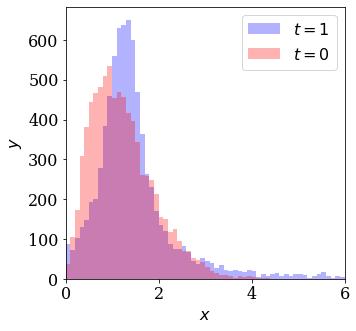

In [5]:
plot_data(data)

### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.

In [6]:
# Fraction of the data assigned as test data
fraction = 0.10
# Split data into a part for training and a part for testing
train_data, test_data = train_test_split(data, test_size=fraction)

# Split the training data into a part for training (fitting) and
# a part for validating the training.
fraction = 1/9
train_data, valid_data = train_test_split(train_data, test_size=fraction)

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train set size:         80000
validation set size:    10000
test set size:          10000


Split data into targets $t$ and inputs $\mathbf{x}$

In [7]:
def split_t_x(df, inputs=['x', 'a', 'c']):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df['target']).astype(np.long)
    x = np.array(df[inputs]).astype(np.float32)
    return (t, x)

train_t, train_x = split_t_x(train_data)
valid_t, valid_x = split_t_x(valid_data)
test_t,  test_x  = split_t_x(test_data)

### Return a (random) batch of data from the training set

In [8]:
def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = rnd.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    return (batch_x, batch_t)

### Empirical risk (that is, average loss)

The empirical risk, which is the __objective function__ we shall minimize, is defined as

\begin{align}
R_M(\theta) & = \frac{1}{M}\sum_{m=1}^M L(t_m, f_m),
\end{align}

where 

\begin{align}
    f_m & \equiv f(\mathbf{x}_m, \theta),\\ \\ \textrm{and} \\
    L(t, f) &= -\ln[f^t \, (1 - f)^{1 - t}], \\
            &= 
\begin{cases}
    -\ln f, & \text{if } t == 1\\
    -\ln (1-f)             & \text{otherwise}.
\end{cases}
\end{align}

The empirical risk $R_M$ approximates the __risk__

\begin{align}
R[f] & = \int \cdots \int \, p(t, \mathbf{x}) \, L(t, f(\mathbf{x}, \theta)) \, dt \, d\mathbf{x},
\end{align}

which is a __functional__ of the model $f$. The quantity $p(t, \mathbf{x}) \, dt\, d\mathbf{x}$ is the probability distribution from which the sample $\{ (t_m, \mathbf{x}_m), m = 1,\cdots, M \}$ is presumed to have been drawn. 

In [21]:
def average_loss(f, t):
    # note: f and t must be of the same shape. 
    # the following implements a ternary operator:
    #    do-this if condition-is-true else do-that
    #losses = torch.where(t > 0.5, torch.log(f), torch.log(1-f))
    losses = (f - t)**2
    return torch.mean(losses) 

### Define accuracy of model

Let's define accuracy as the fraction of the sample that is correctly classified. Recall, that if we use either the __quadratic loss__ 

$$L(t, f) = (t - f)^2$$

or the __cross entropy loss__

$$L(t, f) =- [t \, \ln(f) + (1 - t) \ln(1-f)],$$

the model $f(\mathbf{x}, \theta)$ will approximate the mean of $p(t | \mathbf{x})$, that is,

$$f(\mathbf{x}, \theta^*) \approx p(1 | \mathbf{x}) 
= \frac{p(\mathbf{x} | 1) \, p(1)}{p(\mathbf{x} | 1) \, p(1) + p(\mathbf{x} | 0) \, p(0)},$$

provided that
   1. We have a lot of training data (strictly, an infinite amount).
   2. We have a sufficienty flexible model $\forall \, \mathbf{x}$.
   3. We have an effective optimizer so that we can find the best fit parameter point $\theta^*$.

### Function to execute training loop

Note, here we use $t$ and $y$ interchangeably to denote the targets

In [22]:
def train(model, optimizer, avloss, getbatch,
          train_x, train_t, 
          valid_x, valid_t,
          batch_size, 
          n_iterations, step=10):
    
    xx   = []
    yy_t = []
    yy_v = []
    n    = 5000
    
    # set mode to training so that training specific operations such 
    # as dropout are enabled.
    model.train()
    
    print('Average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    for ii in range(n_iterations):

        # Get a random sample (a batch) of images (as numpy arrays)
        batch_x, batch_t = getbatch(train_x, train_t, batch_size)
        
        # Convert the numpy arrays batch_x and batch_t, to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation with respect to parameters. 
        # However, since we do not need to take the derivatives
        # with respect to x and t, we disable this feature
        with torch.no_grad(): 
            x = torch.from_numpy(batch_x)
            t = torch.from_numpy(batch_t)     

        # compute the output of the model for the batch of data x
        # make sure shape of outputs is the same as shape of targets, t
        outputs = model(x).reshape(t.shape)
        
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # Finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move a single step
        
        if ii % step == 0:
            # compute a validation measure using the model 
            # given its current parameters.
            acc_t = validate(model, train_x[:n], train_t[:n]) 
            acc_v = validate(model, valid_x[:n], valid_t[:n])
            
            # print on same line
            print("\r%10d\t%10.4f\t%10.4f" % (ii, acc_t, acc_v), end='')
        
            xx.append(ii)
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
    return (xx, yy_t, yy_v)

In [23]:
def validate(model, inputs, targets):
    # make sure we set evaluation mode so that training specific
    # operations such as dropout are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and y
        x = torch.from_numpy(inputs)
        t = torch.from_numpy(targets)
        # remember to reshape
        p = model(x).reshape(t.shape)  # predict probabilities p(1|x)
    return average_loss(p, t)

In [24]:
def plot_average_loss(traces):
    
    xx, yy_t, yy_v = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(8, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss", fontsize=FONTSIZE)
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')

    ax.set_xlabel('Iterations', fontsize=FONTSIZE)
    ax.set_ylabel('average loss', fontsize=FONTSIZE)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')

    plt.show()

### Define model $f(\mathbf{x}, \theta)$

$$f(\mathbf{x}, \theta) = \mbox{sigmoid}(b_2 + \mathbf{w}_2 \,(\,\mathbf{b}_1 + \mathbf{w}_1 \, \mbox{relu}(\mathbf{b}_0 + \mathbf{w}_0 \, \mathbf{x}) \, ) \,),$$

Note that the value of this model is a scalar, therefore, $\mathbf{b}_2$ in this exercise is a scalar $b_2$. The model uses the non-linear functions relu as well as:

$$\textrm{sigmoid}(z) = \frac{1}{1 + \exp(-z)}.$$

In [25]:
N_INPUTS  =  3      # number of inputs (x1, x2)    
N_OUTPUTS =  1

# Instead of creating our own class, let's just use the 
# Sequential class since it is sufficient for our simple model.
# Try to guess what's going on here.
model = nn.Sequential(nn.Linear(N_INPUTS, 50),  nn.ReLU(),
                      nn.Linear(50,  50),  nn.ReLU(),
                      nn.Linear(50,  50),  nn.ReLU(),
                      nn.Linear(50, N_OUTPUTS), nn.Sigmoid())

print (model)

Sequential(
  (0): Linear(in_features=3, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): ReLU()
  (6): Linear(in_features=50, out_features=1, bias=True)
  (7): Sigmoid()
)


### Train!

Instantiate an optimizer, then train

Recall, that every step in the iteration is given by

$$\theta_\mbox{new} = \theta_\mbox{current} - \eta \, \nabla R_M,$$

where $\eta$ is called the *learning rate*. We start with a relatively large value of $\eta$ and we gradually decrease it. Why?

In [26]:
n_batch      = 100
n_iterations = 8001
learning_rate= 1.e-2
decay_rate   = 1.e-5  # rate at which to decrease learning_rate

optimizer    = torch.optim.Adam(model.parameters(), 
                                lr=learning_rate,
                                weight_decay=decay_rate)

traces = train(model, optimizer, 
               average_loss,
               get_batch,
               train_x, train_t, 
               valid_x, valid_t,
               n_batch, 
               n_iterations,
               step=10)

Average loss
 iteration	 train-set	 valid-set
      8000	    0.1838	    0.1852

In [27]:
def plot_average_loss(traces):
    
    xx, yy_t, yy_v = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.set_xlim((0, xx[-1]))
    #ax.set_xscale('log')
    ax.set_yscale('log')
    
    plt.plot(xx, yy_t, 'b', label='Training')
    plt.plot(xx, yy_v, 'r', label='Validation')
    plt.xlabel('Iterations', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.grid(True, which="both", linestyle='-')
    plt.legend(loc='upper right')
    plt.show()

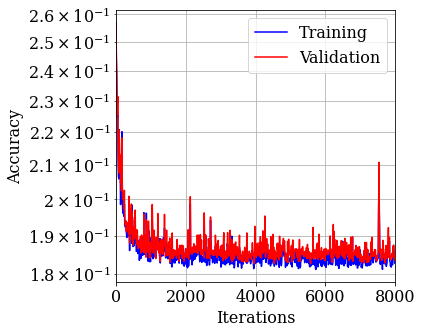

In [28]:
plot_average_loss(traces)

### Plot distribution

In [29]:
def plot_distributions(p, t):
    ps = p[t > 0.5] # probabilities for class with t == 1
    pb = p[t < 0.5] # probabilities for class with t == 0
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.set_xlim(0, 1)

    ax.hist(ps, bins=50, color='b',
            histtype='stepfilled',
            alpha=0.3, label='$t = 1$')
    
    ax.hist(pb, bins=50, color='r',
            histtype='stepfilled',
            alpha=0.3, label='$t = 0$')
    
    ax.set_xlabel('$p(1|x)$', fontsize=FONTSIZE)
    ax.legend(loc='upper right')

    plt.show()

### Compute $p(1 | x)$

In [30]:
def compute_prob(model, xx):
    # convert from numpy array to a torch tensor of type float
    x = torch.from_numpy(xx).float()

    # compute p(1|x)
    p = model(x)

    # squeeze() removes extraneous dimensions
    p = p.squeeze()

    # detach().numpy() converts back to a numpy array
    p = p.detach().numpy()
    return p

In [31]:
p = compute_prob(model, test_x)

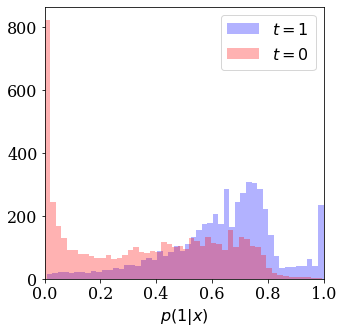

In [33]:
plot_distributions(p, test_t)

### Plot Receiver Operating Characteristic (ROC) curve

In [34]:
def plot_roc_curve(p, t):
    bad, good, _ = roc_curve(t, p)
    roc_auc = auc(bad, good)

    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    ax  = fig.add_subplot(1,1,1)
    
    ax.plot(bad, good, color='red',
            lw=1, label='ROC curve, AUC = %0.2f)' % roc_auc)
    
    ax.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel(r'fraction$(t=0)$', fontsize=18)
    ax.set_ylabel(r'fraction$(t=1)$', fontsize=18)
    ax.legend(loc="lower right", fontsize=14)
    
    plt.savefig('03_likelihood_roc.png')
    plt.show()

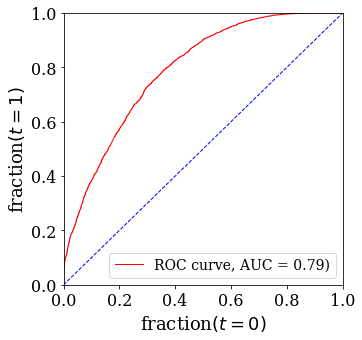

In [36]:
plot_roc_curve(p, test_t)

### Plot approximate likelihood $p(x | \theta, 1)$

In [37]:
def likelihood(x, a, c, model):
    A1 = 1.5 
    C1 = 1.5
    
    X = np.array([(z, a, c) for z in x])
    D = model(torch.tensor(X).float()).squeeze().detach().numpy()
    f = st.gengamma.pdf(x, A1, C1)
    p = f * D / (1-D)
    return p

In [42]:
def plot_gengamma(a, c, model, xmin=0, xmax=4, xstep=0.01):
  
    # create an empty figure
    fig = plt.figure(figsize=(10, 4))
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    
    ax = fig.add_subplot(nrows,ncols,index)
    ax.set_xlabel('$x$', fontsize=FONTSIZE)
    ax.set_ylabel('$p(x|a, c)$', fontsize=FONTSIZE)
    ax.set_xlim([xmin, xmax])
    #ax.set_ylim([0.0, 1.6])
    
    x  = np.arange(xmin, xmax+xstep, xstep)
    kolor = ['red', 'orange', 'brown', 
             'green', 'blue', 'indigo', 'violet']
    i = 0
    for ai, ci in zip(a, c):
        y = st.gengamma.pdf(x, ai, ci)
        ax.plot(x, y, color=kolor[i])
        
        p = likelihood(x, ai, ci, model)
        ax.plot(x, p, color=kolor[i], linestyle='--')
        
        i += 1
        if i >= len(kolor):
            i = 0
    fig.tight_layout()
    plt.show()

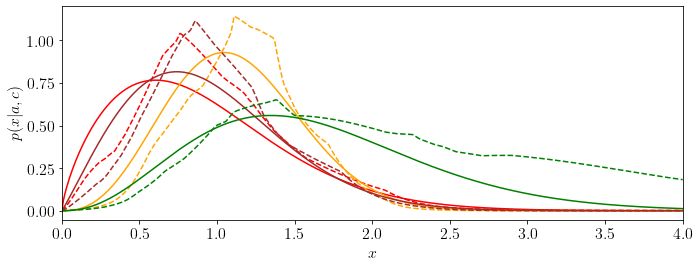

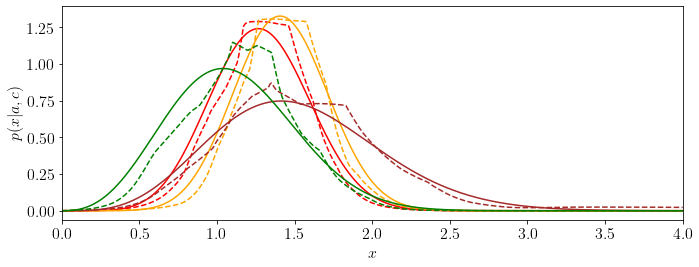

In [43]:
mp.rc('text', usetex=True)
a = rnd.uniform(1.0, 3.0, 8)
c = rnd.uniform(1.0, 3.0, 8)
plot_gengamma(a[:4], c[:4], model)
plot_gengamma(a[4:], c[4:], model)